# Unconstrained Deep Learning  

Train unconstrained deep learning for CIFAR-10 classification using modified LeNet5 based on: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

## Problem Description

We have a simple feed-forward network. The input is an image, which is fed through several layers to obtain the output. The logit output is used to decide the label of the input image. Below is a demo image of LeNet5:
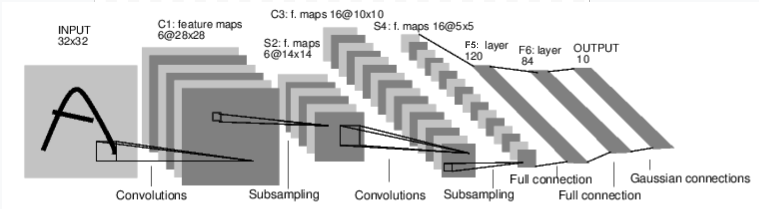

## Modules Importing
Import all necessary modules and add NCVX src folder to system path. 

In [1]:
import time
import torch
import sys
## Adding NCVX directories. Should be modified by user
sys.path.append('/home/buyun/Documents/GitHub/NCVX')
from ncvx import ncvx
from ncvxStruct import Options, GeneralStruct 
from private.getNvar import getNvarTorch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision

## Data Generation 
Specify torch device, neural network architecture, and generate data.

NOTE: please specify path for downloading data.

Use GPU for this problem. If no cuda device available, please set *device = torch.device('cpu')*

In [2]:
device = torch.device('cuda')

class Net(nn.Module):
     def __init__(self):
             super().__init__()
             self.conv1 = nn.Conv2d(3, 6, 5)
             self.conv1_bn = nn.BatchNorm2d(6)
             self.pool = nn.MaxPool2d(2, 2)
             self.conv2 = nn.Conv2d(6, 8, 9)
             self.conv2_bn = nn.BatchNorm2d(8)
             self.fc1 = nn.Linear(8 * 3 * 3, 30)
             self.fc1_bn = nn.BatchNorm1d(30)
             self.fc2 = nn.Linear(30, 20)
             self.fc2_bn = nn.BatchNorm1d(20)
             self.fc3 = nn.Linear(20, 10)

     def forward(self, x):
             x = self.pool(F.elu( self.conv1_bn(self.conv1(x))  ))
             x = self.pool(F.elu( self.conv2_bn(self.conv2(x))  ))
             x = torch.flatten(x, 1) # flatten all dimensions except batch
             x = F.elu( self.fc1_bn(self.fc1(x)) )
             x = F.elu( self.fc2_bn(self.fc2(x)) )
             x = self.fc3(x)
             return x

# fix model parameters
torch.manual_seed(0)
model = Net().to(device=device, dtype=torch.double)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 1000
trainset = torchvision.datasets.CIFAR10(root='/home/buyun/Documents/GitHub/NCVX/examples', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=2)
# data_in
for i, data in enumerate(trainloader, 0):        
    if i >= 1:
         break   
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    
labels = labels.to(device=device ) # label/target [256]
inputs = inputs.to(device=device, dtype=torch.double) # input data [256,3,32,32]

Files already downloaded and verified


## Problem Definition

Specify optimization variables, and objective and constraint(s).

Note: please strictly follow the format of comb_fn and obj_eval_fn, which will be used in the NCVX main algortihm.

In [3]:
# variables and corresponding dimensions.
var_in = {}
var_count = 0
var_str = "x"
for i in model.parameters():
    # print(i.shape)
    var_in[var_str+str(var_count)]= list(i.shape)
    var_count += 1

def obj_eval_fn(X_struct):
    # objective function
    var_str = "x"
    var_count = 0
    for p in model.parameters():
        tmpstr = var_str+str(var_count)
        tmp_parameter = getattr(X_struct,tmpstr)
        tmp_parameter.requires_grad_(True)
        p.data = tmp_parameter # update model parameters
        var_count += 1
    
    outputs = model(inputs)
    criterion = nn.CrossEntropyLoss()
    f = criterion(outputs, labels)
    return f
    

def comb_fn(X_struct):
    # objective function
    var_str = "x"
    var_count = 0
    for p in model.parameters():
        tmpstr = var_str+str(var_count)
        tmp_parameter = getattr(X_struct,tmpstr)
        tmp_parameter.requires_grad_(True)
        p.data = tmp_parameter # update model parameters
        var_count += 1
    
    outputs = model(inputs)
    criterion = nn.CrossEntropyLoss()
    f = criterion(outputs, labels)
    ci = None
    ce = None
    return [f,ci,ce]


## User Options
Specify user-defined options for NCVX 

In [4]:
opts = Options()
nvar = getNvarTorch(model.parameters())
opts.QPsolver = 'osqp' 
opts.maxit = 100
opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
opts.opt_tol = 1e-6
opts.fvalquit = 1e-6
opts.print_level = 1
opts.print_frequency = 10
# opts.print_ascii = True
opts.halt_on_linesearch_bracket = False
opts.max_fallback_level = 3
opts.min_fallback_level = 2
opts.init_step_size = 1e-2
opts.linesearch_maxit = 25
opts.is_backtrack_linesearch = True
opts.searching_direction_rescaling = True
opts.disable_terminationcode_6 = True

## Initial Test 
Check initial accuracy of the modified LeNet5 model

In [5]:
outputs = model(inputs )
acc = (outputs.max(1)[1] == labels).sum().item()/labels.size(0)

print("Initial acc = {}".format(acc)) 

Initial acc = 0.102


/home/buyun/anaconda3/envs/ncvx_cuda_env/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Main Algorithm

In [6]:
start = time.time()
soln = ncvx(combinedFunction = comb_fn, objEvalFunction = obj_eval_fn, var_dim_map = var_in, nn_model= model, torch_device = device, user_opts = opts)
end = time.time()
print("Total Wall Time: {}s".format(end - start))



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════╗
║  NCVX requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.              ║
║  To disable this notice, set opts.quadprog_info_msg = False                               ║
╚═══════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
NCVX: A User-Friendly and Scalable Package for Nonconvex Optimization in Machine Learning     ║ 
Version 1.1.1                                                                                 ║ 
MIT License Copyright (c) 2021 SUN Group @ UMN                                                ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:                      

## Train Accuracy

In [7]:
torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
outputs = model(inputs)
acc = (outputs.max(1)[1] == labels).sum().item()/labels.size(0)
print("Train acc = {}".format(acc))

Train acc = 0.358


## Test Accuracy

In [8]:
testset = torchvision.datasets.CIFAR10(root='/home/buyun/Documents/GitHub/NCVX/examples', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

for i, data in enumerate(testloader, 0):        
    if i >= 3:
         break   
    # get the inputs; data is a list of [inputs, labels]
    test_inputs, test_labels = data
    
test_labels = test_labels.to(device=device ) # label/target [256]
test_inputs = test_inputs.to(device=device, dtype=torch.double) # input data [256,3,32,32]

test_outputs = model(test_inputs)
test_acc = (test_outputs.max(1)[1] == test_labels).sum().item()/test_labels.size(0)
print("Test acc = {}".format(test_acc))

Files already downloaded and verified
Test acc = 0.292


## Continue Training

In [9]:
opts.print_level = 0
for i in range (10):
    # restart
    opts.x0 = soln.final.x
    torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
    soln = ncvx(combinedFunction = comb_fn, objEvalFunction = obj_eval_fn, var_dim_map = var_in, nn_model= model, torch_device = device, user_opts = opts)
    torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
    print("iter %d00:"%(i+2))
    # train acc
    outputs = model(inputs)
    acc = (outputs.max(1)[1] == labels).sum().item()/labels.size(0)
    print("Train acc = {}".format(acc))
    # test acc
    test_outputs = model(test_inputs)
    test_acc = (test_outputs.max(1)[1] == test_labels).sum().item()/test_labels.size(0)
    print("Test acc = {}".format(test_acc))

iter 200:
Train acc = 0.391
Test acc = 0.327
iter 300:
Train acc = 0.433
Test acc = 0.336
iter 400:
Train acc = 0.496
Test acc = 0.336
iter 500:
Train acc = 0.548
Test acc = 0.353
iter 600:
Train acc = 0.575
Test acc = 0.355
iter 700:
Train acc = 0.641
Test acc = 0.344
iter 800:
Train acc = 0.673
Test acc = 0.32
iter 900:
Train acc = 0.713
Test acc = 0.314
iter 1000:
Train acc = 0.741
Test acc = 0.311
iter 1100:
Train acc = 0.783
Test acc = 0.324
